In [1]:
!python --version

Python 3.12.7


In [2]:
import os
import random
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
# Set directory paths
DIRECTORY = r'C:\Users\Admin\Downloads\archive\resized_train_cropped\resized_train_cropped'
LABELS_FILE = r'C:\Users\Admin\Downloads\archive\trainLabels_cropped.csv'

# Load labels
labels_df = pd.read_csv(LABELS_FILE)
labels_dict = dict(zip(labels_df['image'], labels_df['level']))

# Load images and labels
images = []
labels = []

train_image_count = 0

import re

# ...

for filename in os.listdir(DIRECTORY):
    if filename.endswith('.jpeg') and train_image_count < 1000:
        train_image_count += 1
        img = load_img(os.path.join(DIRECTORY, filename), target_size=(256, 256))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)

        base_name = re.sub(r'\s*\(.*\)', '', filename.split('.')[0])
        label = labels_dict.get(base_name)

        if label is not None:
            labels.append(label)
        else:
            # Skip image if label is not found
            images.pop()  # remove the image you just added


images = np.array(images)
labels = np.array(labels)

# Convert labels to one-hot encoding
labels = to_categorical(labels, num_classes=5)  # Assuming there are 5 levels of diabetic retinopathy
print("done")

done


In [4]:
images.shape

(1000, 256, 256, 3)

In [5]:
labels.shape

(1000, 5)

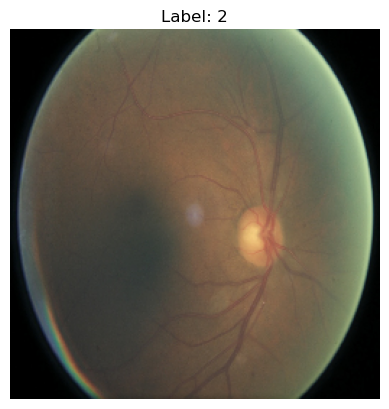

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(images[999])
plt.title(f"Label: {np.argmax(labels[999])}")  # Convert from one-hot to class index
plt.axis('off')
plt.show()

In [8]:
images_flat = images.reshape((images.shape[0], -1))  # Shape: (n_train, 256*256*3)

In [20]:
labels_flat = np.argmax(labels, axis=1) 

In [9]:
images_flat.shape

(1000, 196608)

In [10]:
from sklearn.cluster import KMeans
inertia = []
k = [2, 3, 4, 5, 6, 7]
for i in k:
    kmeans = KMeans(n_clusters=i, init='random', max_iter=500, random_state=42)
    kmeans.fit(images_flat)
    inertia.append(kmeans.inertia_)

C:\Users\Admin\anaconda3\envs\new\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Admin\anaconda3\envs\new\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\envs\new\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\envs\new\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Admin\anaconda3\envs\new\Lib\subprocess.py", line 1538, in _execute_c

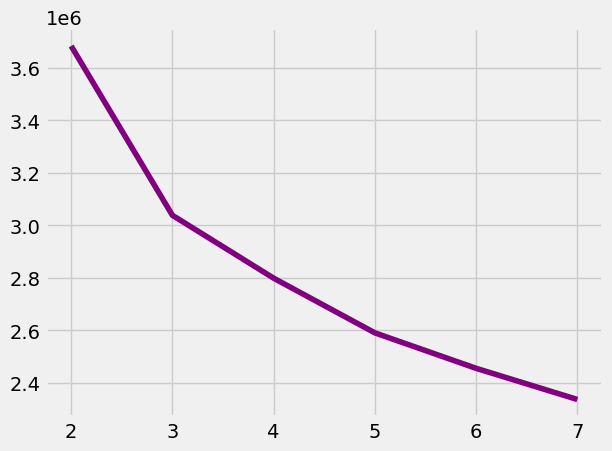

In [11]:
plt.style.use('fivethirtyeight')
plt.plot(k, inertia, color='purple')
plt.xticks(k)
plt.show()

In [13]:
import time
debut = time.time()
kmeans = KMeans(n_clusters=5, max_iter=500, random_state=42)
kmeans.fit(images_flat)
fin = time.time()

y_pred = kmeans.labels_
print(f'temps d entrainement = {fin-debut:.2f} secondes')
print("Number of iterations:", kmeans.n_iter_)

C:\Users\Admin\anaconda3\envs\new\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


temps d entrainement = 25.89 secondes
Number of iterations: 14


In [18]:
y_pred.shape

(1000,)

In [19]:
labels_flat.shape

(1000, 5)

In [21]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

ari = adjusted_rand_score(labels_flat, y_pred)
nmi = normalized_mutual_info_score(labels_flat, y_pred)
homo = homogeneity_score(labels_flat, y_pred)
comp = completeness_score(labels_flat, y_pred)
v_meas = v_measure_score(labels_flat, y_pred)

print(f"ARI: {ari:.3f}")
print(f"NMI: {nmi:.3f}")
print(f"Homogeneity: {homo:.3f}")
print(f"Completeness: {comp:.3f}")
print(f"V-measure: {v_meas:.3f}")


ARI: 0.004
NMI: 0.010
Homogeneity: 0.014
Completeness: 0.008
V-measure: 0.010


In [22]:
from sklearn.metrics import confusion_matrix
import pandas as pd

conf_mat = confusion_matrix(labels_flat, y_pred)
df = pd.DataFrame(conf_mat, 
                  index=[f"True {i}" for i in range(5)],
                  columns=[f"Cluster {i}" for i in range(5)])
print(df)


        Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4
True 0        206        114        142        154        111
True 1         17          4         13         20         12
True 2         32         21         40         36         31
True 3         10          3          7          2          4
True 4          3          6          4          3          5


In [23]:
from sklearn.metrics import silhouette_score

# Compute silhouette score
score = silhouette_score(images_flat, y_pred)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.1580


In [24]:
from sklearn.metrics import davies_bouldin_score
# Get predictions (cluster labels)
dbi_score = davies_bouldin_score(images_flat, y_pred)
print(f"Davies-Bouldin Index: {dbi_score:.4f}")

Davies-Bouldin Index: 1.7661


In [25]:
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(images_flat, y_pred)
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

Calinski-Harabasz Index: 309.5091


In [26]:
import time
debut = time.time()
kmeans = KMeans(n_clusters=3, max_iter=500, random_state=42)
kmeans.fit(images_flat)
fin = time.time()

y_pred = kmeans.labels_
print(f'temps d entrainement = {fin-debut:.2f} secondes')
print("Number of iterations:", kmeans.n_iter_)

C:\Users\Admin\anaconda3\envs\new\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


temps d entrainement = 23.98 secondes
Number of iterations: 7


In [27]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

ari = adjusted_rand_score(labels_flat, y_pred)
nmi = normalized_mutual_info_score(labels_flat, y_pred)
homo = homogeneity_score(labels_flat, y_pred)
comp = completeness_score(labels_flat, y_pred)
v_meas = v_measure_score(labels_flat, y_pred)

print(f"ARI: {ari:.3f}")
print(f"NMI: {nmi:.3f}")
print(f"Homogeneity: {homo:.3f}")
print(f"Completeness: {comp:.3f}")
print(f"V-measure: {v_meas:.3f}")


ARI: -0.008
NMI: 0.007
Homogeneity: 0.008
Completeness: 0.006
V-measure: 0.007


In [28]:
from sklearn.metrics import silhouette_score

# Compute silhouette score
score = silhouette_score(images_flat, y_pred)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.2238


In [29]:
from sklearn.metrics import davies_bouldin_score
# Get predictions (cluster labels)
dbi_score = davies_bouldin_score(images_flat, y_pred)
print(f"Davies-Bouldin Index: {dbi_score:.4f}")

Davies-Bouldin Index: 1.4831


In [30]:
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(images_flat, y_pred)
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

Calinski-Harabasz Index: 455.6065


In [31]:
import time
debut = time.time()
kmeans = KMeans(n_clusters=4, max_iter=500, random_state=42)
kmeans.fit(images_flat)
fin = time.time()

y_pred = kmeans.labels_
print(f'temps d entrainement = {fin-debut:.2f} secondes')
print("Number of iterations:", kmeans.n_iter_)

C:\Users\Admin\anaconda3\envs\new\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


temps d entrainement = 23.05 secondes
Number of iterations: 16


In [32]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

ari = adjusted_rand_score(labels_flat, y_pred)
nmi = normalized_mutual_info_score(labels_flat, y_pred)
homo = homogeneity_score(labels_flat, y_pred)
comp = completeness_score(labels_flat, y_pred)
v_meas = v_measure_score(labels_flat, y_pred)

print(f"ARI: {ari:.3f}")
print(f"NMI: {nmi:.3f}")
print(f"Homogeneity: {homo:.3f}")
print(f"Completeness: {comp:.3f}")
print(f"V-measure: {v_meas:.3f}")

ARI: -0.005
NMI: 0.011
Homogeneity: 0.014
Completeness: 0.009
V-measure: 0.011


In [35]:
from sklearn.metrics import silhouette_score

# Compute silhouette score
score = silhouette_score(images_flat, y_pred)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.1493


In [33]:
from sklearn.metrics import davies_bouldin_score
# Get predictions (cluster labels)
dbi_score = davies_bouldin_score(images_flat, y_pred)
print(f"Davies-Bouldin Index: {dbi_score:.4f}")

Davies-Bouldin Index: 1.8861


In [34]:
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(images_flat, y_pred)
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

Calinski-Harabasz Index: 352.1271


In [36]:
class K_Means(object):
    # Initialize input values n_clusters and max_iter   
    def __init__(self, n_clusters, max_iter):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    # Function that assigns points to a cluster
    def assign_points_to_cluster(self, X):
        # Label points according to the minimum euclidean distance
        self.labels_ = [self._nearest(self.cluster_centers_, x) for x in X]
        # Map labels to data points
        indices=[]
        for j in range(self.n_clusters):
            cluster=[]
            for i, l in enumerate(self.labels_):
                if l==j: cluster.append(i)
            indices.append(cluster)
        X_by_cluster = [X[i] for i in indices]
        return X_by_cluster
    
    # Function that randomly selects initial centroids
    def initial_centroid(self, X):
        initial = np.random.permutation(X.shape[0])[:self.n_clusters]
        return X[initial]

    # Function that updates centroids and repeats 
    # assign_points_to_cluster until convergence or max_iter is reached
    def train_fun(self, X):  
        # initialize centroids      
        self.cluster_centers_ = self.initial_centroid(X)
        # process of assigning points to clusters until convergence or until max_iter is reached
        for i in range(self.max_iter):
            X_by_cluster = self.assign_points_to_cluster(X)
            # calculate the new centers 
            new_centers=[c.sum(axis=0)/len(c) for c in X_by_cluster]
            new_centers = [arr.tolist() for arr in new_centers]
            old_centers=self.cluster_centers_
            # if the new centroid are the same as the old centroids then the algorithm has converged
            if np.all(new_centers == old_centers): 
                self.number_of_iter=i
                break;
            else: 
                # set self.cluster_centers_ as new centers 
                self.cluster_centers_ = new_centers
        self.number_of_iter=i
        print(f'number of iterations{i}')
        return self
    
    # Function that calculates the minimum euclidean distance
    def _nearest(self, clusters, x):
        return np.argmin([self._distance(x, c) for c in clusters])
    
    # Function to calculate euclidean distance between two points
    def _distance(self, a, b):
        return np.sqrt(((a - b)**2).sum())

    # Function that returns predicted clusters for each point
    def predict(self, X):
        return self.labels_

In [39]:
debut = time.time()
seq_kmeans = K_Means(3, 500)
seq_kmeans.train_fun(images_flat)
fin = time.time()

print(f'temps d entrainement = {fin-debut:.2f} secondes')

number of iterations6
temps d entrainement = 410.47 secondes


In [41]:
# Get predictions (cluster labels)
predicted_labels = seq_kmeans.predict(images_flat)
dbi_score = davies_bouldin_score(images_flat, predicted_labels)
print(f"Davies-Bouldin Index: {dbi_score:.4f}")

Davies-Bouldin Index: 1.4927


In [42]:
ch_score = calinski_harabasz_score(images_flat, predicted_labels)
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

Calinski-Harabasz Index: 455.8892


In [43]:
from sklearn.metrics import silhouette_score

# Compute silhouette score
score = silhouette_score(images_flat, predicted_labels)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.2216


In [46]:
class cust_K_Means(object):
    def __init__(self, n_clusters, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol  # Convergence tolerance
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None
        self.number_of_iter = 0
    
    def _initialize_centroids(self, X):
        """Randomly select initial centroids"""
        indices = np.random.permutation(X.shape[0])[:self.n_clusters]
        return X[indices].copy()
    
    def _compute_distances(self, X, centers):
        """
        Vectorized distance computation - MUCH faster!
        Returns: (n_samples, n_clusters) array of distances
        """
        # Expand dimensions for broadcasting
        # X: (n_samples, n_features) -> (n_samples, 1, n_features)
        # centers: (n_clusters, n_features) -> (1, n_clusters, n_features)
        distances = np.sqrt(((X[:, np.newaxis, :] - centers[np.newaxis, :, :]) ** 2).sum(axis=2))
        return distances
    
    def _assign_clusters(self, X, centers):
        """Assign each point to nearest cluster - VECTORIZED"""
        distances = self._compute_distances(X, centers)
        return np.argmin(distances, axis=1)
    
    def _compute_centroids(self, X, labels):
        """Compute new centroids - VECTORIZED"""
        new_centers = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centers[k] = cluster_points.mean(axis=0)
            else:
                # Handle empty cluster - reinitialize randomly
                new_centers[k] = X[np.random.randint(X.shape[0])]
        return new_centers
    
    
    def fit(self, X):
        """Train K-Means on data X"""
        X = np.array(X)
        
        # Initialize centroids
        self.cluster_centers_ = self._initialize_centroids(X)
        
        for i in range(self.max_iter):
            # Assign points to clusters
            labels = self._assign_clusters(X, self.cluster_centers_)
            
            # Compute new centroids
            new_centers = self._compute_centroids(X, labels)
            
            # Check convergence (centroid shift)
            center_shift = np.sqrt(((new_centers - self.cluster_centers_) ** 2).sum())
            
            # Update centroids
            self.cluster_centers_ = new_centers
            self.labels_ = labels
            
            # Check convergence
            if center_shift < self.tol:
                self.number_of_iter = i + 1
                print(f'Converged after {i + 1} iterations')
                break
        else:
            self.number_of_iter = self.max_iter
            print(f'Max iterations ({self.max_iter}) reached')
        
        
        return self
    
    def predict(self, X):
        """Predict cluster labels for new data"""
        X = np.array(X)
        return self._assign_clusters(X, self.cluster_centers_)

In [47]:
debut = time.time()
seq_cust_kmeans = cust_K_Means(3, 500)
seq_cust_kmeans.fit(images_flat)
fin = time.time()

print(f'temps d entrainement = {fin-debut:.2f} secondes')

Converged after 16 iterations
temps d entrainement = 106.16 secondes


In [50]:
import numpy as np
import ray

@ray.remote
class Worker:
    """Ray worker for distributed K-Means computation"""
    
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
    
    def compute_distances_and_assign(self, X_chunk, centroids):
        """
        Compute distances and assign clusters for a data chunk
        Returns: labels and partial centroid sums
        """
        centroids = np.array(centroids)
        X_chunk = np.array(X_chunk)
        
        # Vectorized distance computation
        distances = np.sqrt(((X_chunk[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2).sum(axis=2))
        labels = np.argmin(distances, axis=1)
        
        # Compute partial sums and counts for each cluster
        partial_sums = np.zeros((self.n_clusters, X_chunk.shape[1]))
        counts = np.zeros(self.n_clusters, dtype=int)
        
        for k in range(self.n_clusters):
            mask = labels == k
            counts[k] = np.sum(mask)
            if counts[k] > 0:
                partial_sums[k] = X_chunk[mask].sum(axis=0)
        
        return labels, partial_sums, counts
    


class K_Means_Distributed:
    """Distributed K-Means using Ray for parallel computation"""
    
    def __init__(self, n_clusters, max_iter=300, tol=1e-4, num_workers=4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.num_workers = num_workers
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None
        self.number_of_iter = 0
    
    def _initialize_centroids(self, X):
        """Randomly select initial centroids"""
        indices = np.random.permutation(X.shape[0])[:self.n_clusters]
        return X[indices].copy()
    
    def fit(self, X):
        """Train distributed K-Means on data X"""
        X = np.array(X)
        
        # Initialize Ray (done in main program as requested)
        # ray.init() should be called before creating K_Means_Distributed
        
        # Create workers
        workers = [Worker.remote(self.n_clusters) for _ in range(self.num_workers)]
        
        # Initialize centroids
        self.cluster_centers_ = self._initialize_centroids(X)
        
        # Split data into chunks for workers
        X_chunks = np.array_split(X, self.num_workers)
        chunk_refs = [ray.put(chunk) for chunk in X_chunks]
        
        for iteration in range(self.max_iter):
            # Distribute work: compute distances and assign clusters
            futures = [
                worker.compute_distances_and_assign.remote(chunk_ref, self.cluster_centers_)
                for worker, chunk_ref in zip(workers, chunk_refs)
            ]
            results = ray.get(futures)
            
            # Aggregate results from all workers
            all_labels = []
            total_sums = np.zeros((self.n_clusters, X.shape[1]))
            total_counts = np.zeros(self.n_clusters, dtype=int)
            
            for labels_chunk, partial_sums, counts in results:
                all_labels.extend(labels_chunk)
                total_sums += partial_sums
                total_counts += counts
            
            self.labels_ = np.array(all_labels)
            
            # Compute new centroids from aggregated data
            new_centers = np.zeros((self.n_clusters, X.shape[1]))
            for k in range(self.n_clusters):
                if total_counts[k] > 0:
                    new_centers[k] = total_sums[k] / total_counts[k]
                else:
                    # Handle empty cluster - reinitialize randomly
                    new_centers[k] = X[np.random.randint(X.shape[0])]
            
            # Check convergence
            if self.tol is not None:
                center_shift = np.sqrt(((new_centers - self.cluster_centers_) ** 2).sum())
                self.cluster_centers_ = new_centers
                
                if center_shift < self.tol:
                    self.number_of_iter = iteration + 1
                    print(f'Converged after {iteration + 1} iterations')
                    break
            else:
                self.cluster_centers_ = new_centers
        else:
            self.number_of_iter = self.max_iter
            print(f'Max iterations ({self.max_iter}) reached')
        
        return self
    
    def predict(self, X):
        """Predict cluster labels for new data (non-distributed for simplicity)"""
        X = np.array(X)
        distances = np.sqrt(((X[:, np.newaxis, :] - self.cluster_centers_[np.newaxis, :, :]) ** 2).sum(axis=2))
        return np.argmin(distances, axis=1)
    
    def fit_predict(self, X):
        """Fit and return cluster labels"""
        self.fit(X)
        return self.labels_

In [ ]:
ray.init(num_cpus= 4)
print(ray.cluster_resources())
start = time.time()
kmeans_dist = K_Means_Distributed(n_clusters=3, max_iter=500, num_workers=4)
kmeans_dist.fit(X)
end = time.time()
print(f'temps d entrainement = {fin-debut:.2f} secondes')

2025-10-03 18:19:52,517	ERROR services.py:1355 -- Failed to start the dashboard , return code 3221226505
2025-10-03 18:19:52,519	ERROR services.py:1380 -- Error should be written to 'dashboard.log' or 'dashboard.err'. We are printing the last 20 lines for you. See 'https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#logging-directory-structure' to find where the log file is.
2025-10-03 18:19:52,547	ERROR services.py:1424 -- 
The last 20 lines of C:\Users\Admin\AppData\Local\Temp\ray\session_2025-10-03_18-19-46_283140_3144\logs\dashboard.log (it contains the error message from the dashboard): 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\envs\new\Lib\site-packages\ray\dashboard\dashboard.py", line 246, in <module>
    logging_utils.redirect_stdout_stderr_if_needed(
  File "C:\Users\Admin\anaconda3\envs\new\Lib\site-packages\ray\_private\logging_utils.py", line 49, in redirect_stdout_stderr_if_needed
    sys.stderr = open_log(stderr_f

In [ ]:
ray.shutdown()